# Fundamentals of Machine Learning (CSCI-UA.473)
## Lab 11 : Reinforcement Learning

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import random
import time
import matplotlib.pyplot as plt
from IPython import display
from itertools import count

#### Define the multi-armed bandit environment

In [2]:
class MultiArmedBandit:
    def __init__(self, n_bandits, true_probs):
        self.n_bandits = n_bandits
        self.true_probs = true_probs

    def pull(self, bandit):
        return 1 if np.random.random() < self.true_probs[bandit] else 0

#### Define the epsilon-greedy agent

In [3]:
class EpsilonGreedyAgent:
    def __init__(self, n_bandits, epsilon, decay_rate):
        self.n_bandits = n_bandits
        self.epsilon = epsilon
        self.rewards = np.zeros(n_bandits)
        self.counts = np.zeros(n_bandits)
        self.decay_rate = decay_rate

    def choose_bandit(self):
        if np.random.random() < self.epsilon:
            ret = np.random.randint(self.n_bandits)  # Explore
        else:
            ret = np.argmax(self.rewards / (self.counts + 1e-10))  # Exploit
        self.epsilon *= self.decay_rate
        return ret

    def update_rewards(self, bandit, reward):
        self.counts[bandit] += 1
        self.rewards[bandit] += reward

def run_simulation(n_bandits, true_probs, epsilon, n_steps, decay_rate=1):
    bandit = MultiArmedBandit(n_bandits, true_probs)
    agent = EpsilonGreedyAgent(n_bandits, epsilon, decay_rate=decay_rate)
    rewards = []

    for t in range(n_steps):
        bandit_choice = agent.choose_bandit()
        reward = bandit.pull(bandit_choice)
        agent.update_rewards(bandit_choice, reward)
        rewards.append(reward)

    return np.cumsum(rewards) / (np.arange(n_steps) + 1)

We also add an agent that implements a decay along with the epsilon greedy strategy.

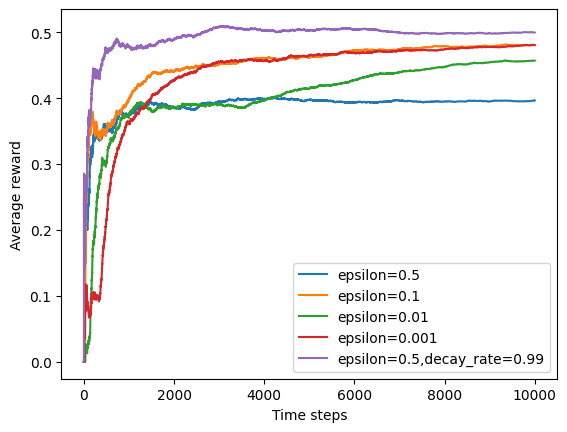

In [7]:
n_bandits = 5
true_probs = [0.1, 0.2, 0.3, 0.4, 0.5]
n_steps = 10000

# Run simulations with different exploration rates
epsilons = [0.5, 0.1, 0.01, 0.001]
for epsilon in epsilons:
    avg_rewards = run_simulation(n_bandits, true_probs, epsilon, n_steps)
    plt.plot(avg_rewards, label=f"epsilon={epsilon}")
epsilon=0.5   
avg_rewards = run_simulation(n_bandits, true_probs, epsilon, n_steps, decay_rate=0.99)
plt.plot(avg_rewards, label=f"epsilon={epsilon},decay_rate=0.99")

plt.xlabel("Time steps")
plt.ylabel("Average reward")
plt.legend()
plt.show()

Next we simulate a multi-armed bandit problem using the Upper Confidence Bound (UCB) algorithm. 
The UCB algorithm balances exploration and exploitation by selecting the bandit with the highest upper confidence bound on its true reward. The upperconfidence bound is given by : $Q_t(a) + \sqrt{\frac{2ln(t)}{N_t(a)}}$ where $Q_t(a)$ is the estimate of action $a$ at time $t$ and $N_t(a)$ is the number of times the action $a$ was selected in the past.

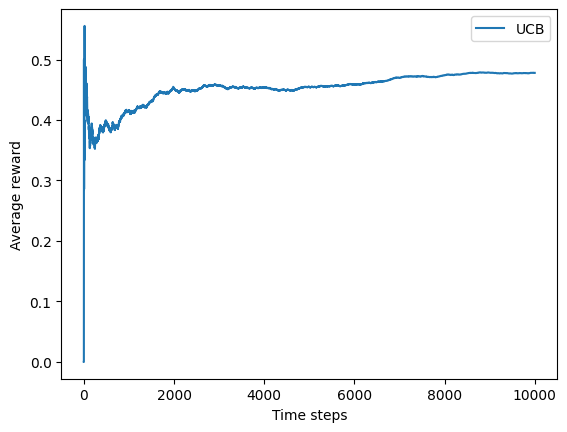

In [8]:
class UCBAgent:
    def __init__(self, n_bandits):
        self.n_bandits = n_bandits
        self.rewards = np.zeros(n_bandits)
        self.counts = np.zeros(n_bandits)

    def choose_bandit(self, t):
        # Add a small constant to avoid division by zero
        ucb_values = self.rewards / (self.counts + 1e-10) + np.sqrt(2 * np.log(t+1) / (self.counts + 1e-10))
        return np.argmax(ucb_values)

    def update_rewards(self, bandit, reward):
        self.counts[bandit] += 1
        self.rewards[bandit] += reward

def run_simulation(n_bandits, true_probs, n_steps):
    bandit = MultiArmedBandit(n_bandits, true_probs)
    agent = UCBAgent(n_bandits)
    rewards = []

    for t in range(n_steps):
        bandit_choice = agent.choose_bandit(t)
        reward = bandit.pull(bandit_choice)
        agent.update_rewards(bandit_choice, reward)
        rewards.append(reward)

    return np.cumsum(rewards) / (np.arange(n_steps) + 1)

n_bandits = 5
true_probs = [0.1, 0.2, 0.3, 0.4, 0.5]
n_steps = 10000

avg_rewards = run_simulation(n_bandits, true_probs, n_steps)

plt.plot(avg_rewards, label="UCB")
plt.xlabel("Time steps")
plt.ylabel("Average reward")
plt.legend()
plt.show()

Now, we include a "dangerous" bandit that has a probability of "killing" the agent if it is pulled. 
In this case, the agent's exploration could lead to its early expiration

Agent expired at step 51.


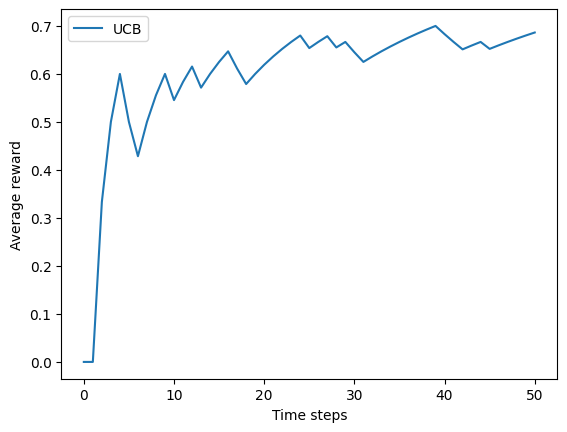

In [11]:
class MultiArmedBandit:
    def __init__(self, n_bandits, true_probs, danger_bandit, danger_prob):
        self.n_bandits = n_bandits
        self.true_probs = true_probs
        self.danger_bandit = danger_bandit
        self.danger_prob = danger_prob

    def pull(self, bandit):
        if bandit == self.danger_bandit:
            return -1 if np.random.random() < self.danger_prob else 1
        return 1 if np.random.random() < self.true_probs[bandit] else 0

class UCBAgent:
    def __init__(self, n_bandits):
        self.n_bandits = n_bandits
        self.rewards = np.zeros(n_bandits)
        self.counts = np.zeros(n_bandits)

    def choose_bandit(self, t):
        ucb_values = self.rewards / (self.counts + 1e-10) + np.sqrt(2 * np.log(t+1) / (self.counts + 1e-10))
        return np.argmax(ucb_values)

    def update_rewards(self, bandit, reward):
        self.counts[bandit] += 1
        self.rewards[bandit] += reward

def run_simulation(n_bandits, true_probs, danger_bandit, danger_prob, n_steps):
    bandit = MultiArmedBandit(n_bandits, true_probs, danger_bandit, danger_prob)
    agent = UCBAgent(n_bandits)
    rewards = []

    for t in range(n_steps):
        bandit_choice = agent.choose_bandit(t)
        reward = bandit.pull(bandit_choice)

        if reward == -1:
            print(f"Agent expired at step {t}.")
            break

        agent.update_rewards(bandit_choice, reward)
        rewards.append(reward)

    return np.cumsum(rewards) / (np.arange(len(rewards)) + 1)

n_bandits = 5
true_probs = [0.1, 0.2, 0.3, 0.4, 0.5]
danger_bandit = 4  # The last bandit is dangerous
danger_prob = 0.05  # Probability of "death" when pulling the dangerous bandit
n_steps = 2000

avg_rewards = run_simulation(n_bandits, true_probs, danger_bandit, danger_prob, n_steps)

plt.plot(avg_rewards, label="UCB")
plt.xlabel("Time steps")
plt.ylabel("Average reward")
plt.legend()
plt.show()

## Designing a self-driving car
Next we will use a simulated environment to design a self-driving car. OpenAI's gym package provides several such simulations.
The core gym interface is <b>env</b>, which is the unified environment interface. The following are the env methods that would be quite helpful to us:

* <b>env</b>.reset() : Resets the environment and returns a random initial state.
* <b>env</b>.step(action) : Step the environment by one timestep. Returns
    * observation: Observations of the environment 
    * reward: If your action was beneficial or not
    * done: Indicates if we have successfully picked up and dropped off a passenger, also called one episode
    * info: Additional info such as performance and latency for debugging purposes
* <b>env</b>.render() : Renders one frame of the environment (helpful in visualizing the environment)
 

In [ ]:
import gym

env = gym.make("Taxi-v3", render_mode="rgb_array")
ACTION_SIZE = env.action_space.n
print(env.action_space)
print(env.observation_space)

Here's our restructured problem statement (from Gym docs):

"There are four designated locations in the grid world indicated by R(ed), G(reen), Y(ellow), and B(lue). When the episode starts, the taxi starts off at a random square and the passenger is at a random location. The taxi drives to the passenger’s location, picks up the passenger, drives to the passenger’s destination (another one of the four specified locations), and then drops off the passenger. Once the passenger is dropped off, the episode ends."

### Actions
There are 6 discrete deterministic actions:

* 0: move south

* 1: move north

* 2: move east

* 3: move west

* 4: pickup passenger

* 5: drop off passenger

### Observations
There are 500 discrete states since there are 25 taxi positions, 5 possible locations of the passenger (including the case when the passenger is in the taxi), and 4 destination locations.

Note that there are 400 states that can actually be reached during an episode. The missing states correspond to situations in which the passenger is at the same location as their destination, as this typically signals the end of an episode. Four additional states can be observed right after a successful episodes, when both the passenger and the taxi are at the destination. This gives a total of 404 reachable discrete states.

Each state space is represented by the tuple: (taxi_row, taxi_col, passenger_location, destination)

An observation is an integer that encodes the corresponding state. The state tuple can then be decoded with the “decode” method.

Passenger locations:

* 0: R(ed)

* 1: G(reen)

* 2: Y(ellow)

* 3: B(lue)

* 4: in taxi

Destinations:

* 0: R(ed)

* 1: G(reen)

* 2: Y(ellow)

* 3: B(lue)

### Rewards:
* -1 per step unless other reward is triggered.

* +20 delivering passenger.

* -10 executing “pickup” and “drop-off” actions illegally.

In [ ]:
# Lets have a look at our environment simulated by gym
env.reset()
img = plt.imshow(env.render()) # only call this once

First, lets try to solve this environment using a brute force approach of just sampling actions and taking them until we reach the goal.

In [ ]:
epochs = 0
penalties, reward = 0, 0
frames = []
done = False

def clear_output() :
    frames = []
    env.reset()
    done = False

clear_output()
while not done:
    action = env.action_space.sample()
    state, reward, done, info, _ = env.step(action)

    if reward == -10:
        penalties += 1
    
    # Put each rendered frame into dict for animation
    frames.append({
        'frame': env.render(),
        'state': state,
        'action': action,
        'reward': reward
        }
    )

    epochs += 1
    
    
print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))

In [ ]:
%matplotlib inline
from matplotlib import animation
from IPython.display import HTML
    
def show_video(video) :

    fig = plt.figure()
    im = plt.imshow(video[0]['frame'])

    plt.close() # this is required to not display the generated image

    def init():
        im.set_data(video[0]['frame'])

    def animate(i):
        im.set_data(video[i]['frame'])
        return im

    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=min(len(video),4000),
                                   interval=50)
    return anim.to_html5_video()

In [ ]:
HTML(show_video(frames))

Not good. It takes thousands of timesteps and makes lots of wrong drop offs to deliver just one passenger to the right destination.

This is because we aren't learning from past experience. We can run this over and over, and it will never optimize. The agent has no memory of which action was best for each state, which is exactly what Reinforcement Learning will do for us.

## Q-Learning
Q-learning lets the agent use the environment's rewards to learn, over time, the best action to take in a given state.

In our Taxi environment, we have the reward table, $P$, that the agent will learn from. It does this by receiving a reward for taking an action in the current state, then updating a Q-value to remember if that action was beneficial. The values stored in the Q-table are called Q-values, and they map to a (state, action) combination.

A Q-value for a particular state-action combination is representative of the "quality" of an action taken from that state. Better Q-values imply better chances of getting higher rewards. For example, if the taxi is faced with a state that includes a passenger at its current location, it is highly likely that the Q-value for pickup is higher when compared to other actions, like dropoff or north. Q-values are initialized to an arbitrary value, and as the agent exposes itself to the environment and receives different rewards by executing different actions, the Q-values are updated using the equation:

$$ Q(state, action) \leftarrow (1 - \alpha) Q(state,action) + \alpha \Big( reward + \gamma \max_a Q(nextState, actions) \Big) $$
where $\alpha$ is the learning rate - similar to supervised learning - and $\gamma$ is the discount factor.

In [ ]:
# initialize the Q-table
q_table = np.zeros([env.observation_space.n, env.action_space.n])

The learning process can be surmised as :
* Initialize the Q-table by all zeros.
* Start exploring actions: For each state, select any one among all possible actions for the current state (S).
* Travel to the next state (S') as a result of that action (a).
* For all possible actions from the state (S') select the one with the highest Q-value.
* Update Q-table values using the equation.
* Set the next state as the current state.
* If goal state is reached, then end and repeat the process.

Further, there is a tradeoff between exploration (choosing a random action) and exploitation (choosing actions based on already learned Q-values). We want to prevent the action from always taking the same route, and possibly overfitting, so we'll be introducing another parameter called $\epsilon$ to cater to this during training.

In [ ]:
# Hyperparameters
alpha = 0.1
gamma = 0.6
epsilon = 1

# For plotting metrics
all_epochs = []
all_penalties = []

for i in range(1, 1001):
    state = env.reset()[0]

    epochs, penalties, reward, = 0, 0, 0
    done = False
    
    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample() # Explore action space
        else:
            action = np.argmax(q_table[state]) # Exploit learned values

        next_state, reward, done, info,_ = env.step(action) 
        
        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])
        
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        if reward == -10:
            penalties += 1

        state = next_state
        epochs += 1
        
    if i % 100 == 0:
        clear_output()
        print(f"Episode: {i}")

print("Training finished.\n")

Now that the Q-table has been established over 10,000 episodes, lets evaluate how our agent did!

In [ ]:
total_epochs, total_penalties = 0, 0
episodes = 10
episode_frames = {}
for i in range(episodes):
    state = env.reset()[0]
    epochs, penalties, reward = 0, 0, 0
    
    done = False
    frames = []
    
    while not done:
        action = np.argmax(q_table[state])
        state, reward, done, info,_ = env.step(action)
        frames.append({
            'frame': env.render(),
            'state': state,
            'action': action,
            'reward': reward
            })

        if reward == -10:
            penalties += 1

        epochs += 1
    episode_frames[i] = frames
    total_penalties += penalties
    total_epochs += epochs

print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Average penalties per episode: {total_penalties / episodes}")

In [ ]:
HTML(show_video(episode_frames[5]))

## Deep Q Network
The Q-value can be modelled by a deep neural network - https://arxiv.org/pdf/1312.5602.pdf
We can use PyTorch to define a network to learn the Q-value function. We will be using the CartPole-v0 environment provided by OpenAI Gym. The environment is described as <br/><i >"A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum starts upright, and the goal is to prevent it from falling over by increasing and reducing the cart’s velocity."<i /><br />
    
An <b>episode</b> terminates when : <br/>
1. Pole Angle is more than ±12° <br/>
2. Cart Position is more than ±2.4 (center of the cart reaches the edge of the display) <br/>
3. Episode length is greater than 200. <br/>

The <b>reward</b> is 1 for every step taken, including the termination step.

In [ ]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
from torch import randint
import gym
from time import sleep
from copy import deepcopy
from collections import deque,namedtuple
import math

# def print_frames(frames, episode_num):
#     img = plt.imshow(frames[0]) # only call this once
#     plt.title(f"Episode : {episode_num}")
#     plt.axis('off')
#     for i, frame in enumerate(frames):
#         img.set_data(frames[i])
#         display.display(plt.gcf())
#         display.clear_output(wait=True)

As described, a DQN is a Q-value function approximator. At each time step, we pass the current environment observations as input. The output is the Q-value corresponding to each possible action. In Supervised Learning, we have a ground truth corresponding to each input data point. The network prediction can be compared against the corresponding ground truth for training. What are our ground truths here? <br /><br />

The training algorithm can be described as,
* Initialize game state and get initial observations.
* Input the observation (obs) to Q-network and get Q-value corresponding to each action. Store the maximum of the q-value in X.
* With a probability, epsilon selects random action otherwise select action corresponding to max q-value. 
* Execute the selected action in the game state and collect the generated reward( $r_t$ ) and next state observation(obs_next).
* Pass these next state observation through Q-network and store the maximum of these Q-values in a variable say $q_{t+1}$. If the discount factor is $\gamma$ then the ground truth can be calculated as :
$$Y = r_t + \gamma * q_{t+1}$$
* Take X as the predicted return of current state and Y as the actual return. Calculate loss and perform an optimization step.
* Set obs = obs_next.
* Repeat Step-2 to Step-7 for n episodes.

### Environment
We will initialize the cartpole environment where the task is simply defined as, "The agent has to decide between two actions - moving the cart left or right - so that the pole attached to it stays upright." We will first check the average reward that a random agent can earn. This agent selects actions randomly i.e without using any environment information.

In [ ]:
rew_arr = []
video_frames = []
episode_count = 5
env = gym.make('CartPole-v1',render_mode='rgb_array')
for i in range(episode_count):
    # print(f"Episode : {i}")
    obs, done, rew = env.reset(), False, 0
    frames = []
    while (done != True) :
        A =  randint(0,env.action_space.n,(1,))
        obs, reward, done, info,_ = env.step(A.item())
        rew += reward
        frames.append({"frame" : env.render(), "reward" : rew})
    rew_arr.append(rew)
    video_frames.append(frames)
    # print_frames(frames,i)
    print(f"Total Rewards : {rew}")

In [ ]:
print(len(video_frames[0]))

In [ ]:
HTML(show_video(video_frames[4]))

We’ll be using experience replay memory for training our DQN. It stores the transitions that the agent observes, allowing us to reuse this data later. By sampling from it randomly, the transitions that build up a batch are decorrelated. It has been shown that this greatly stabilizes and improves the DQN training procedure.

In [ ]:
# Define tuple representing a single transition in our environment
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

# Define class to model the replay memory
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        """Sample a random batch of transitions for training"""
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

Our model will be a feed forward neural network that takes in the difference between the current and previous screen patches. It has two outputs, representing $Q(s,\text{left})$ and $Q(s, \text{right})$ (where $s$ is the input to the network). In effect, the network is trying to predict the expected return of taking each action given the current input.

In [ ]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

We define two functions :
* <b>select_action</b> - will select an action accordingly to an epsilon greedy policy. Simply put, we’ll sometimes use our model for choosing the action, and sometimes we’ll just sample one uniformly. The probability of choosing a random action will start at EPS_START and will decay exponentially towards EPS_END. EPS_DECAY controls the rate of the decay.
* <b>plot_durations</b> - a helper for plotting the duration of episodes, along with an average over the last 100 episodes (the measure used in the official evaluations). The plot will be underneath the cell containing the main training loop, and will update after every episode.

In [ ]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

Our aim is to learn a policy to maximize the discounted rewards.

In [ ]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [ ]:
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 200
video_frames = []
for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    frames = []
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        # frames[i_episode].append(env.render())
        frames.append({"frame" : env.render(), "reward" : reward})
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            video_frames.append(frames)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

In [ ]:
print(len(video_frames))

In [ ]:
HTML(show_video(video_frames[190]))